# **Advanced Machine Learning 2022**  
## **Assignment** 2
 
---

Rajas Vaidya MDS202131
Rishika Tibrewal MDS202135
Shreyansh Rastogi MDS202144 

# Variational Autoencoders

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Convert vector to image
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x   


# Display images, n=max number of images to show
def display_images(in_raw, out_raw, n=1):
    out_raw = out_raw[:n]
    if in_raw is not None:
        in_raw = in_raw[:n]
        in_pic = to_img(in_raw.cpu().data).view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.imshow(in_pic[i])
            plt.axis('off')
    out_pic = to_img(out_raw.cpu().data).view(-1, 28, 28)
    plt.figure(figsize=(18, 6))
    for i in range(n):   
        plt.subplot(1,n,i+1)
        plt.imshow(out_pic[i])
        plt.axis('off')
    plt.show()

### Data Loaders

In [ ]:
# Define data loading step

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True, transform=img_transform),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=img_transform),
    batch_size=32, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



## The VAE model

In [ ]:
class VAE(nn.Module):
    def __init__(self, d=20):
        super().__init__()
        self.d = d #latent dimension
        
        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Tanh()
        )

    def sampler(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.sampler(mu, logvar)
        return self.decoder(z), mu, logvar
    
    def generate(self, N=10):
        z = torch.randn((N, self.d)).to(device)
        gen_img = self.decoder(z)
        return gen_img


## The Loss function

In [ ]:
def loss_function(x_hat, x, mu, logvar, beta=1):
    #recon_loss = nn.functional.binary_cross_entropy(
    recon_loss = nn.functional.mse_loss(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return recon_loss + beta * KLD

## Train the VAE

====> Test set loss: 533.8535


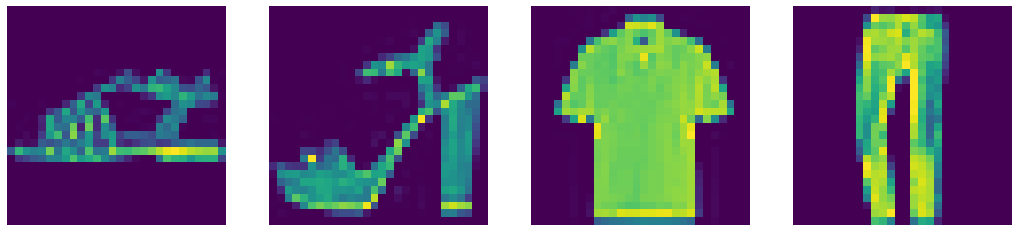

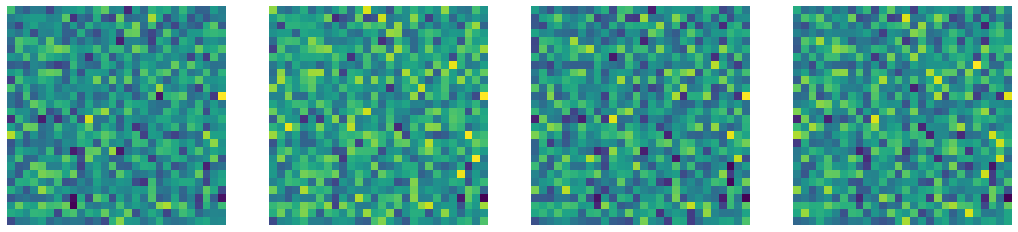

====> Epoch: 1 Average loss: 117.6631
====> Test set loss: 78.2802


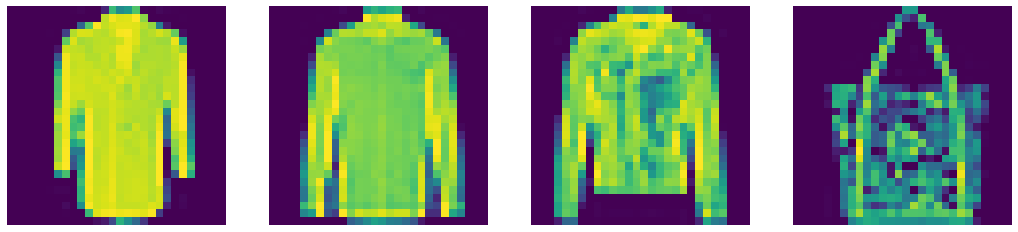

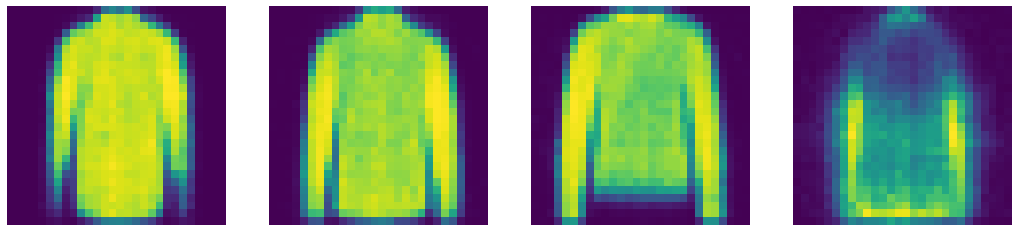

====> Epoch: 2 Average loss: 79.8657
====> Test set loss: 69.2427


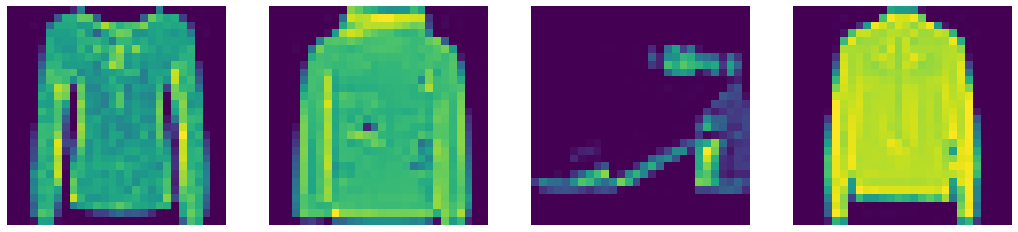

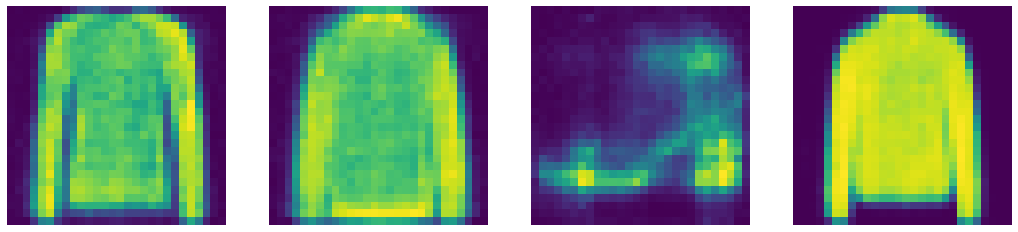

====> Epoch: 3 Average loss: 74.2220
====> Test set loss: 65.4649


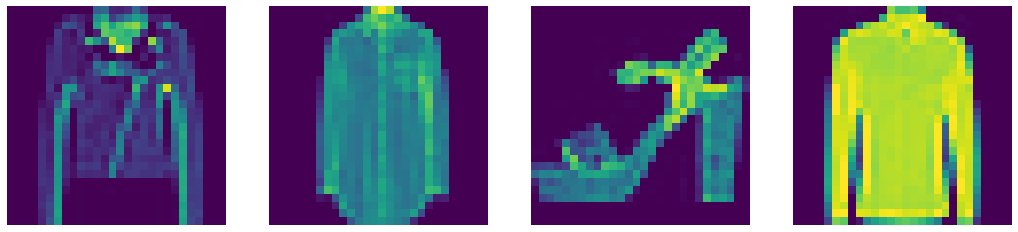

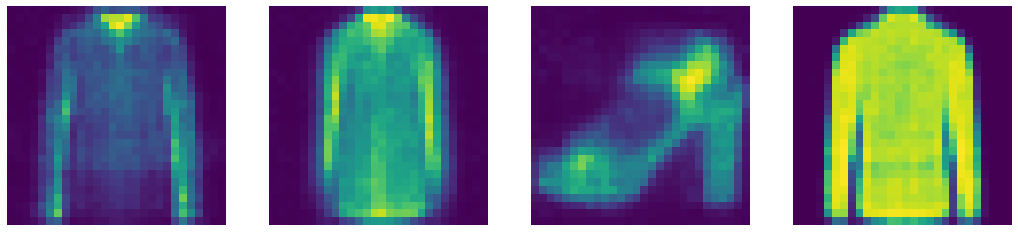

====> Epoch: 4 Average loss: 71.4491
====> Test set loss: 64.2695


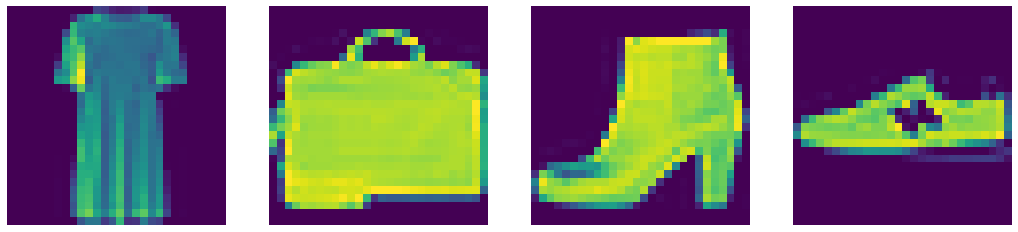

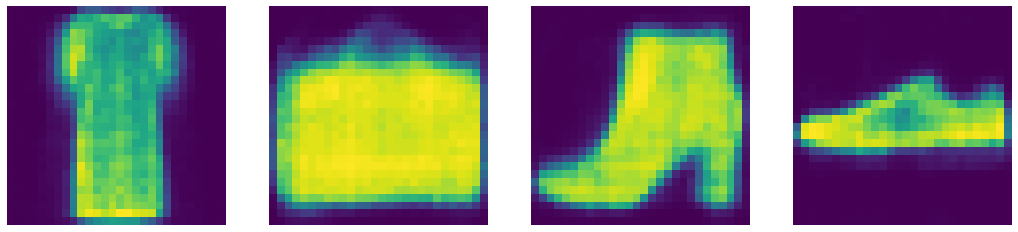

====> Epoch: 5 Average loss: 69.7669
====> Test set loss: 61.9677


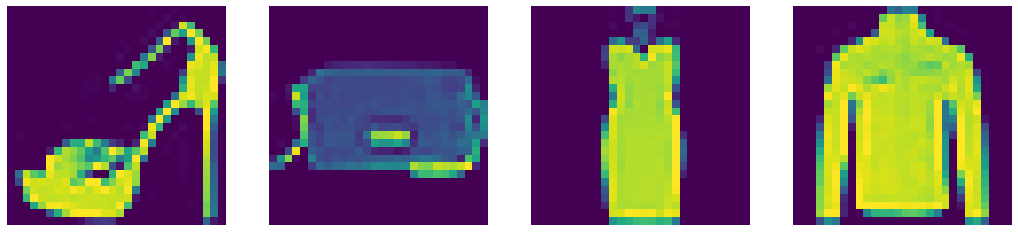

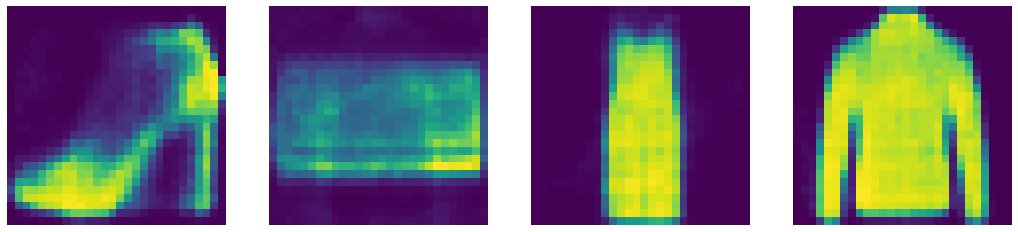

====> Epoch: 6 Average loss: 68.5834
====> Test set loss: 61.7593


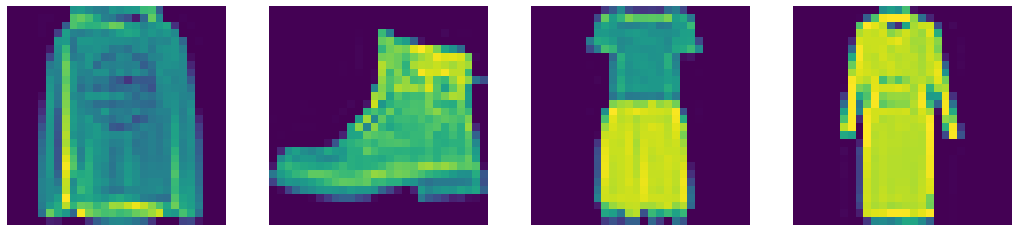

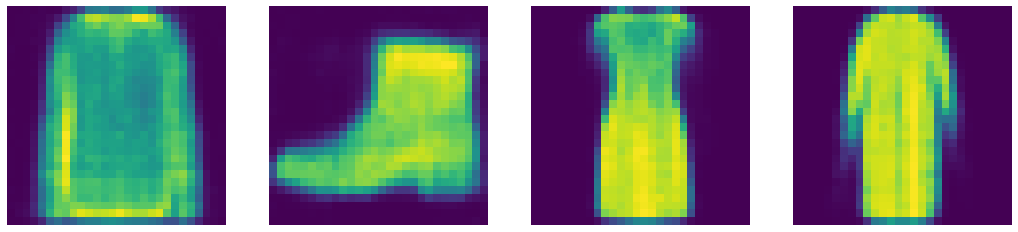

====> Epoch: 7 Average loss: 67.5903
====> Test set loss: 59.6968


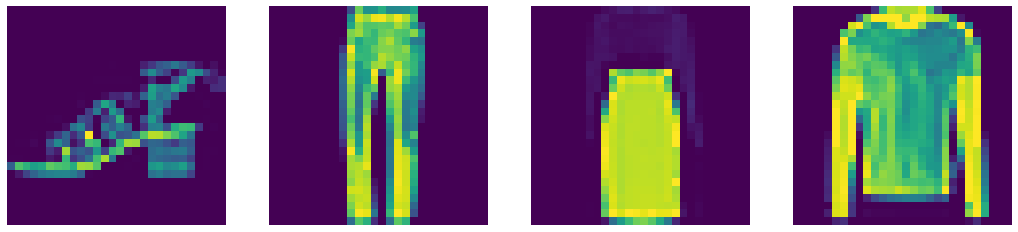

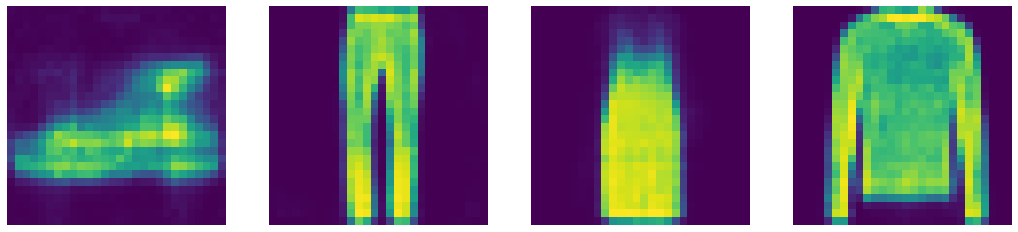

====> Epoch: 8 Average loss: 66.9407
====> Test set loss: 60.1941


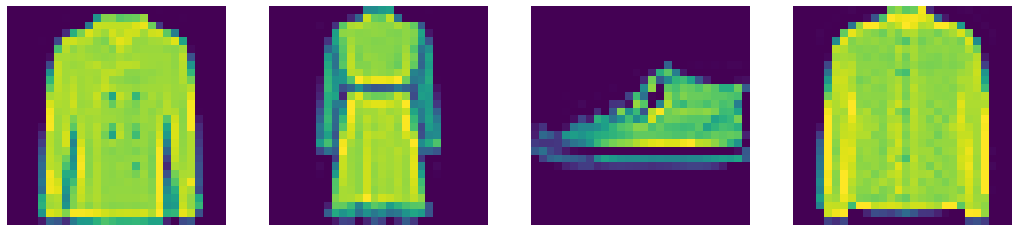

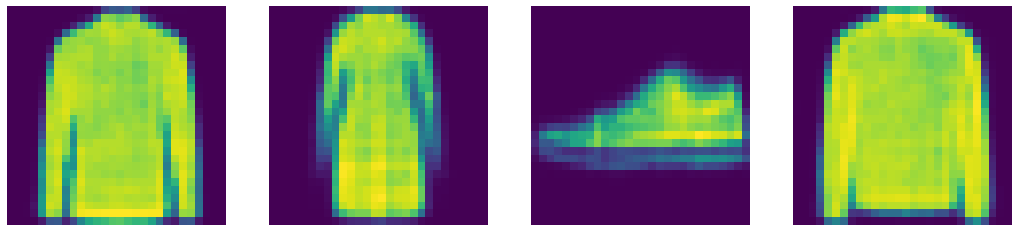

====> Epoch: 9 Average loss: 66.2899
====> Test set loss: 59.5033


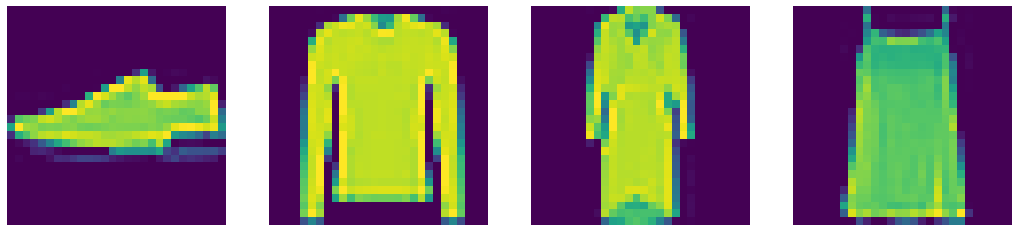

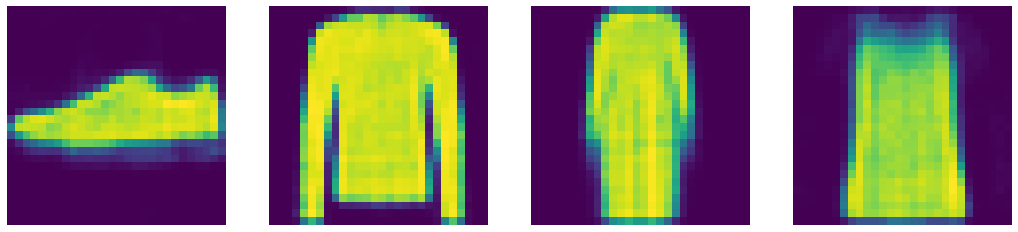

====> Epoch: 10 Average loss: 65.7854
====> Test set loss: 58.8046


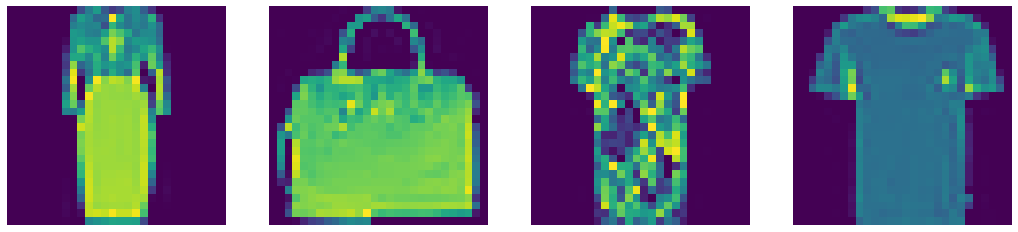

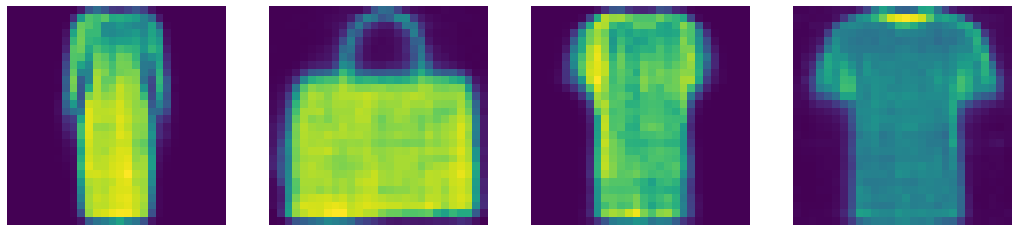

====> Epoch: 11 Average loss: 65.3273
====> Test set loss: 57.9776


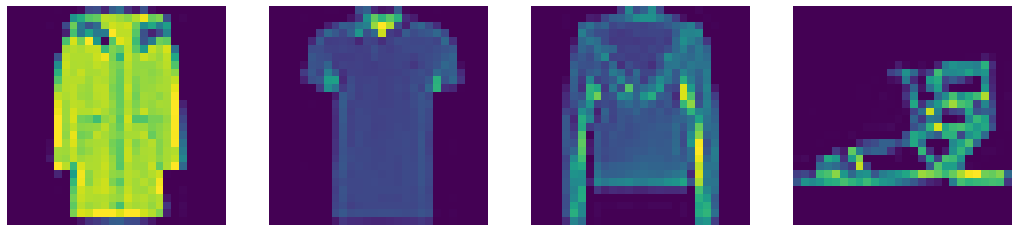

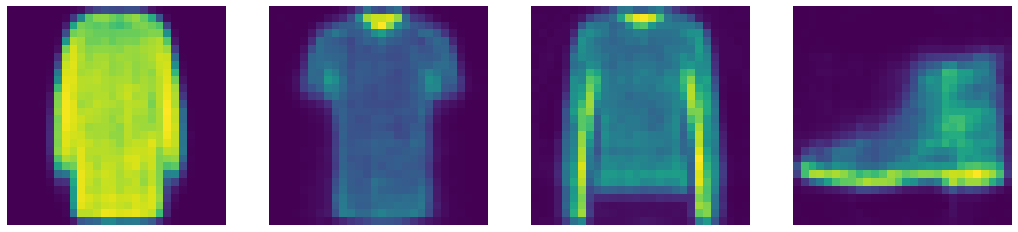

====> Epoch: 12 Average loss: 64.9216
====> Test set loss: 58.6436


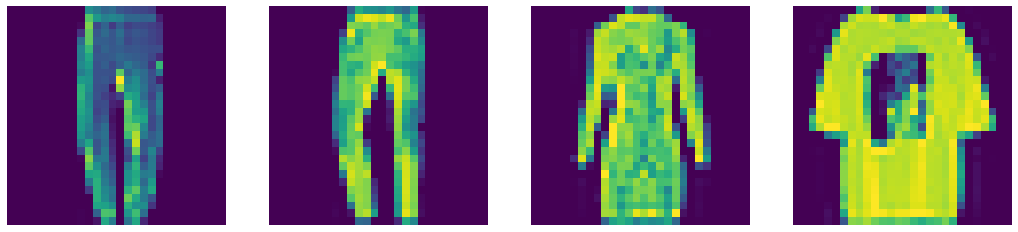

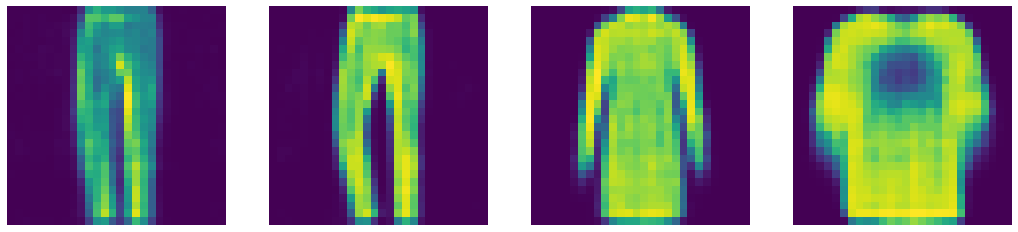

====> Epoch: 13 Average loss: 64.5294
====> Test set loss: 57.8573


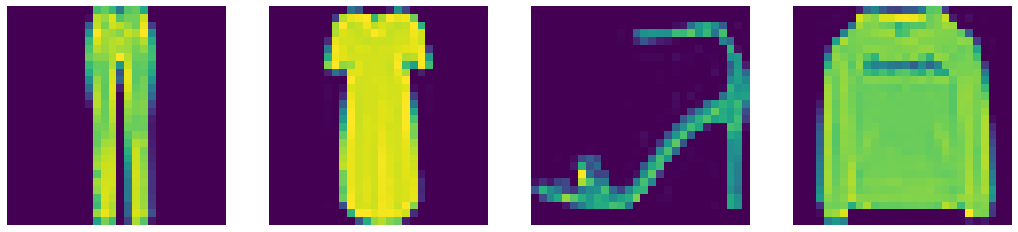

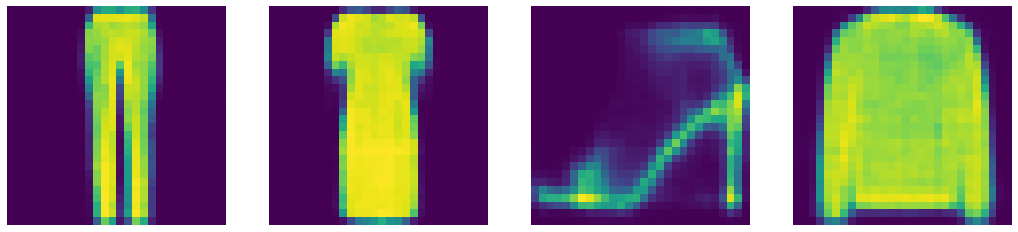

====> Epoch: 14 Average loss: 64.2798
====> Test set loss: 57.5025


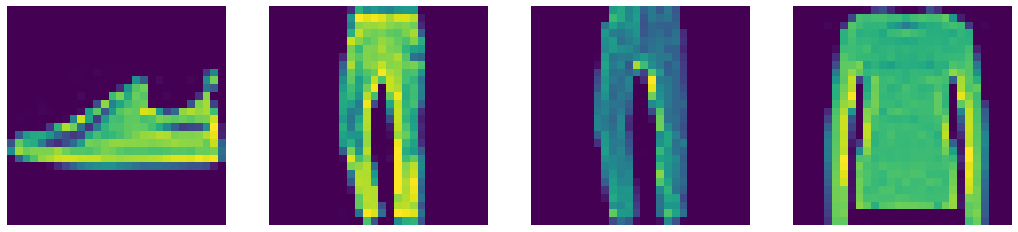

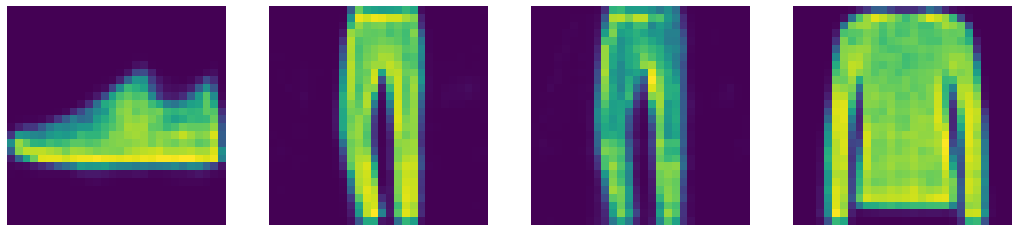

====> Epoch: 15 Average loss: 64.0458
====> Test set loss: 58.1286


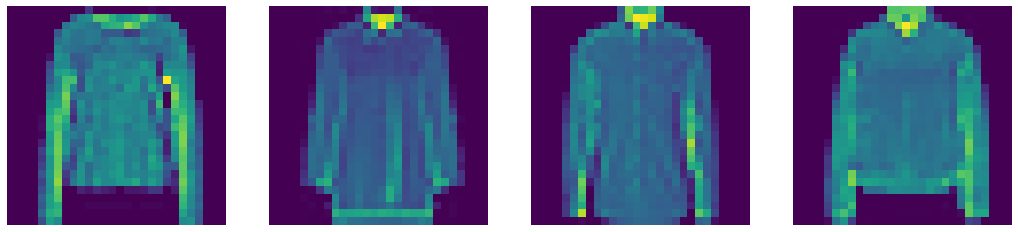

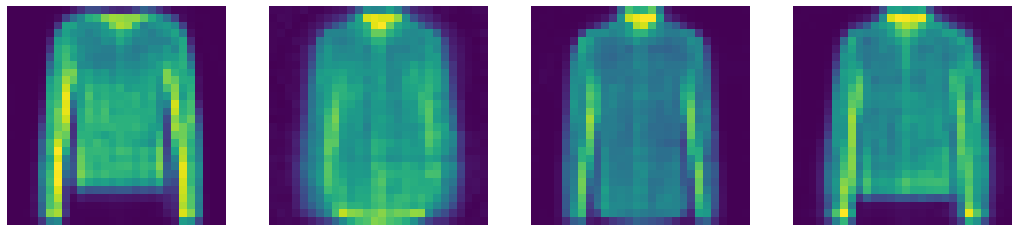

====> Epoch: 16 Average loss: 63.7005
====> Test set loss: 57.2767


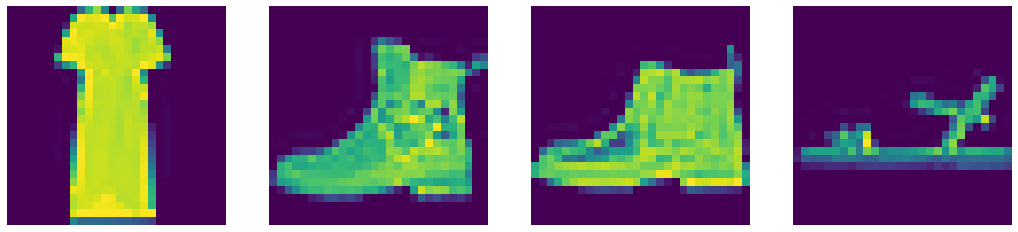

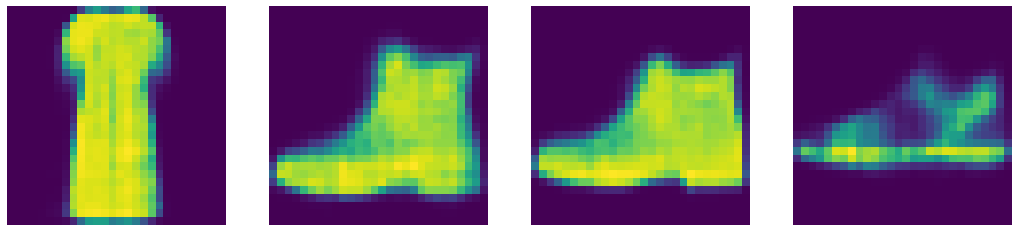

====> Epoch: 17 Average loss: 63.5186
====> Test set loss: 57.0203


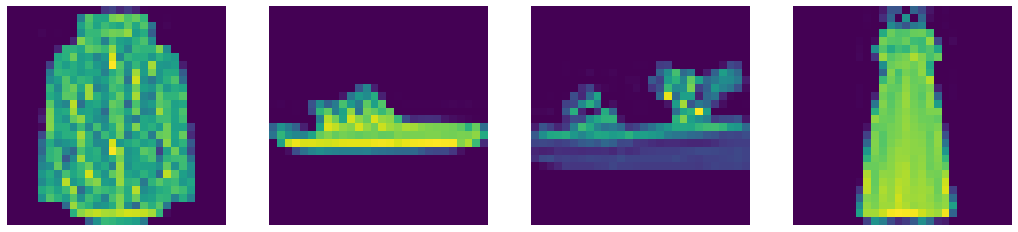

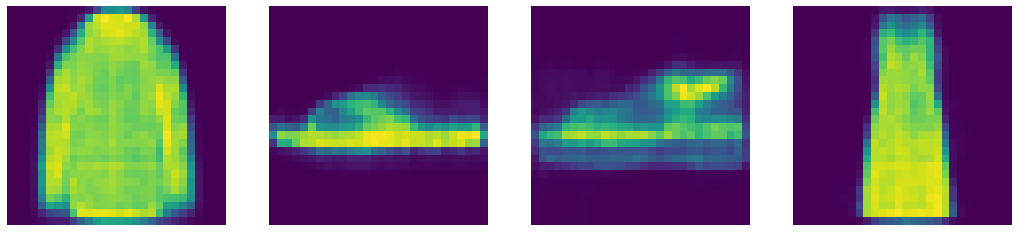

====> Epoch: 18 Average loss: 63.2779
====> Test set loss: 56.9360


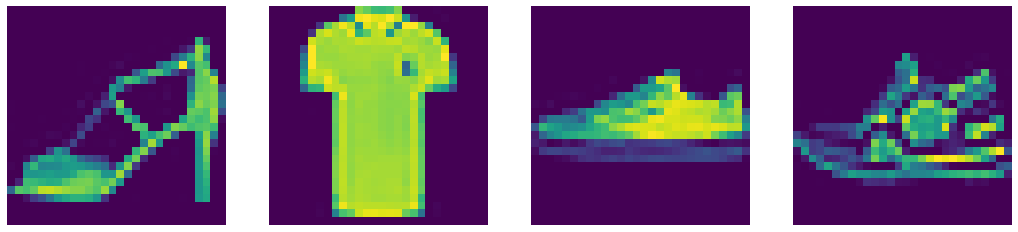

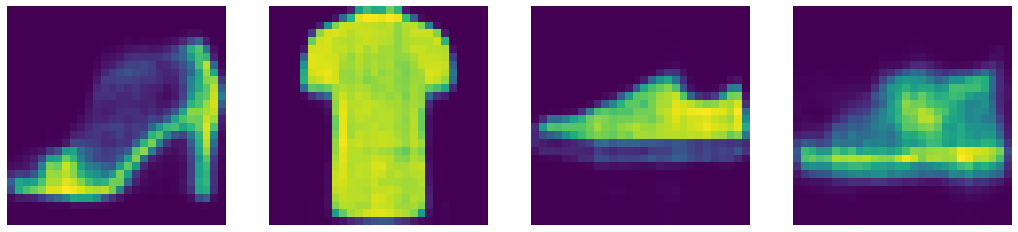

====> Epoch: 19 Average loss: 63.0548
====> Test set loss: 57.5140


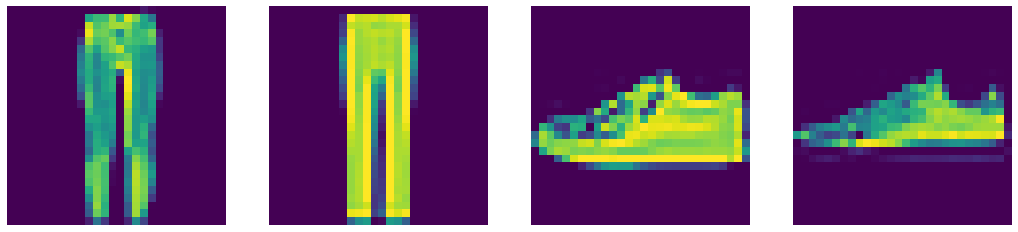

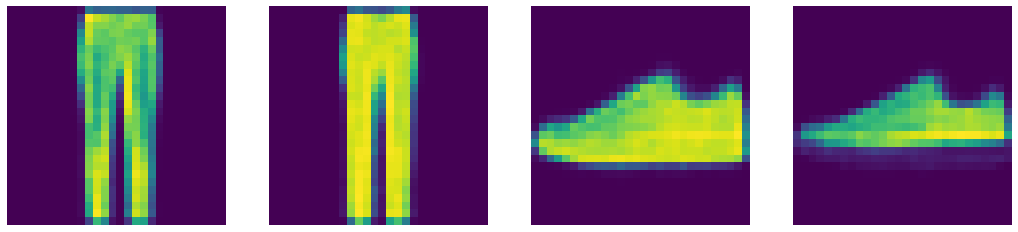

====> Epoch: 20 Average loss: 62.9165
====> Test set loss: 56.5018


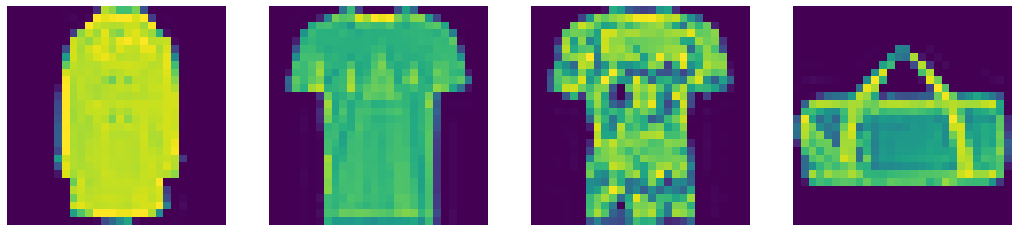

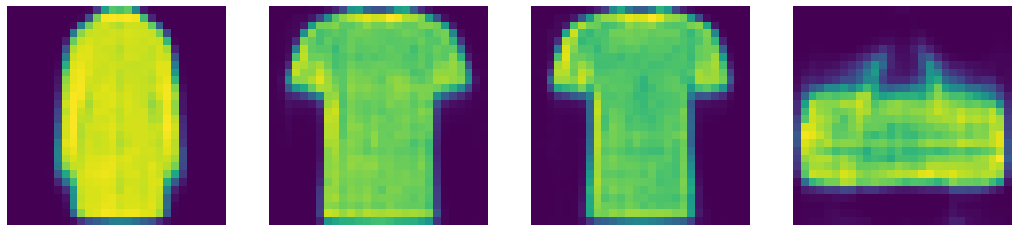

In [ ]:
model = VAE().to(device)

# Setting the optimiser
learning_rate = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

epochs = 20
codes = dict(mu=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['mu'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 4)

### Generating a few images from randomly sampled z

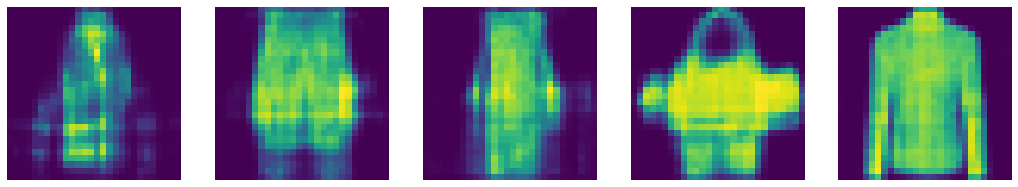

In [ ]:
N=5
display_images(None, model.generate(N), N)

## Let us interpolate between two images

### 1

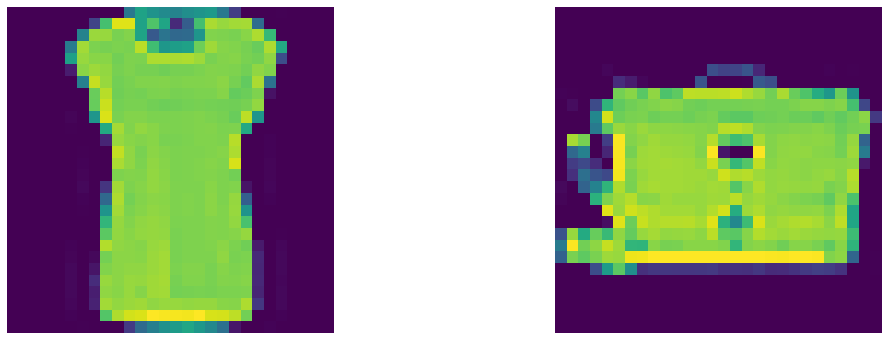

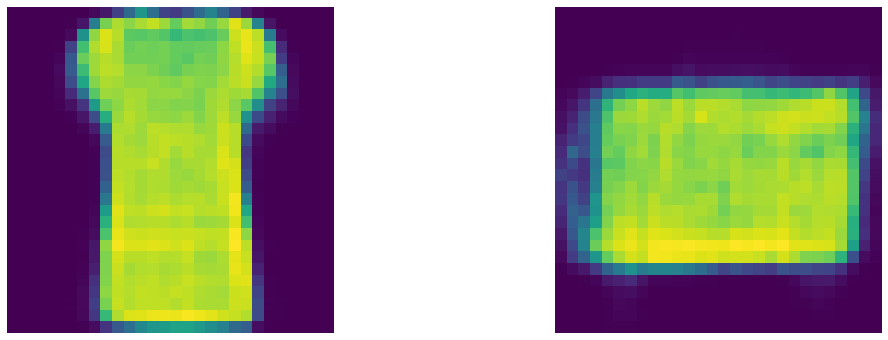

In [ ]:
x, _ = next(iter(test_loader))
x_hat, mu, logvar = model(x)
A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
#sample = torch.stack((x_hat[A].data, x_hat[B].data), 0)
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1)
)), 0), 2)
display_images(None, torch.stack(((
    sample.data[0],
    sample.data[1]
)), 0), 2)

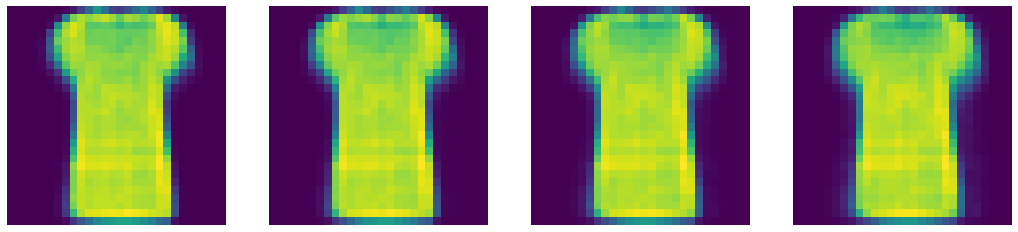

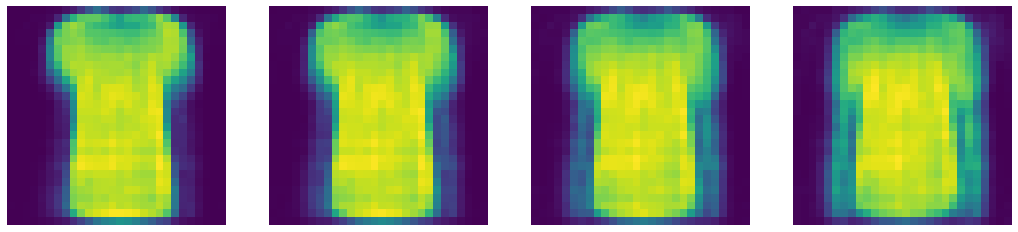

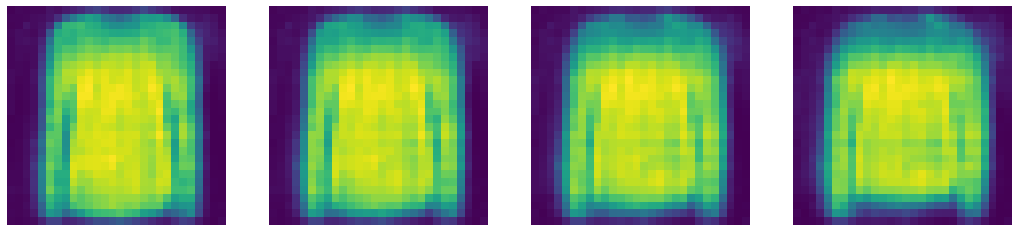

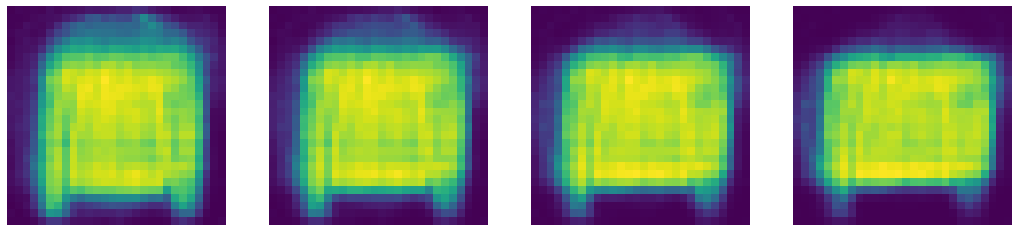

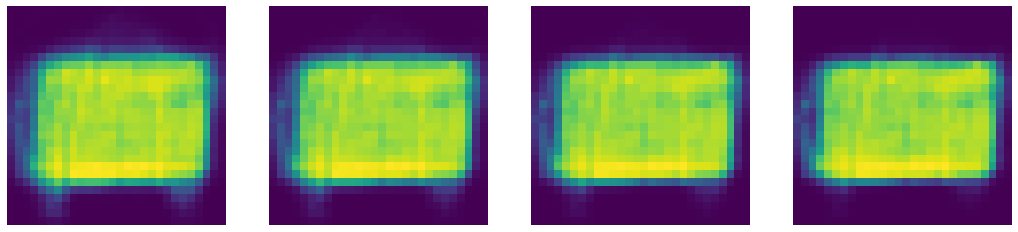

In [ ]:
# Perform an interpolation between input A and B, in N steps
N = 20
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
    sample = model.decoder(code)
for i in range(N//4):
    display_images(None, sample[i*4:4*(i+1)], 4)

### 2

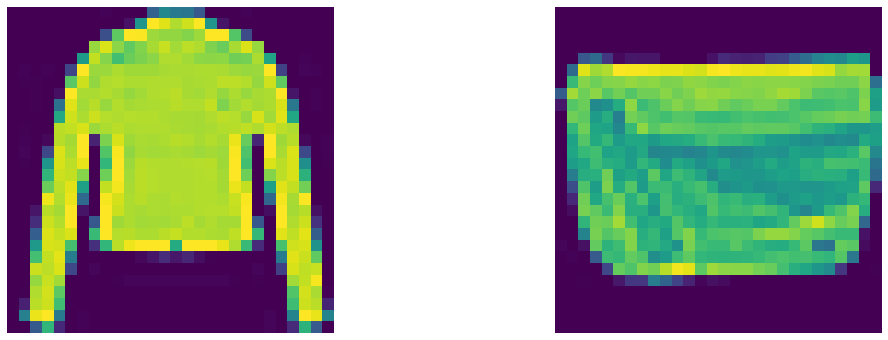

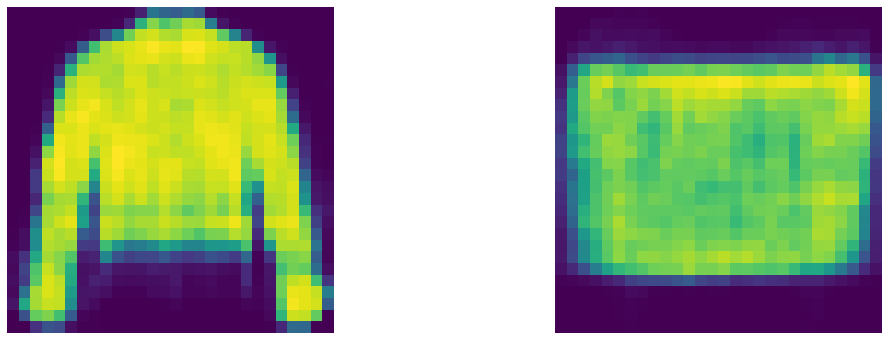

In [ ]:
x, _ = next(iter(test_loader))
x_hat, mu, logvar = model(x)
A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
#sample = torch.stack((x_hat[A].data, x_hat[B].data), 0)
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1)
)), 0), 2)
display_images(None, torch.stack(((
    sample.data[0],
    sample.data[1]
)), 0), 2)

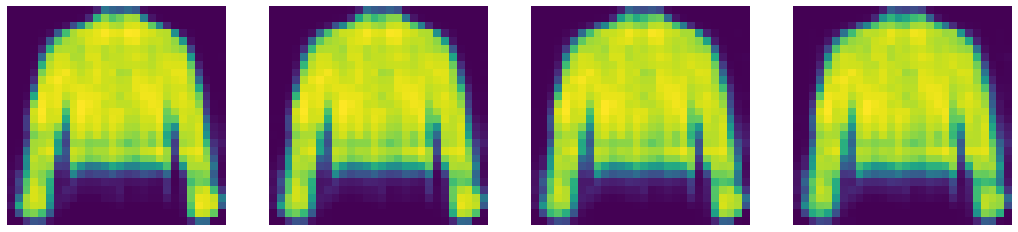

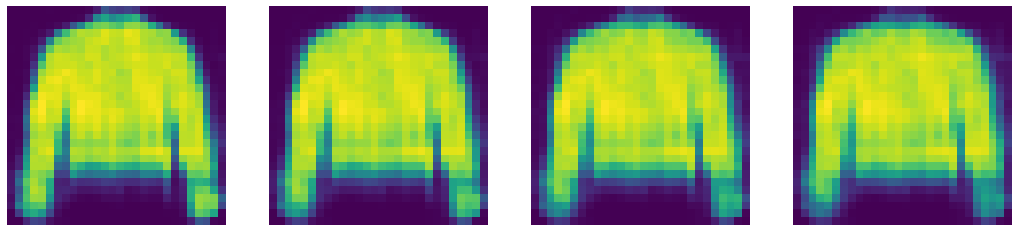

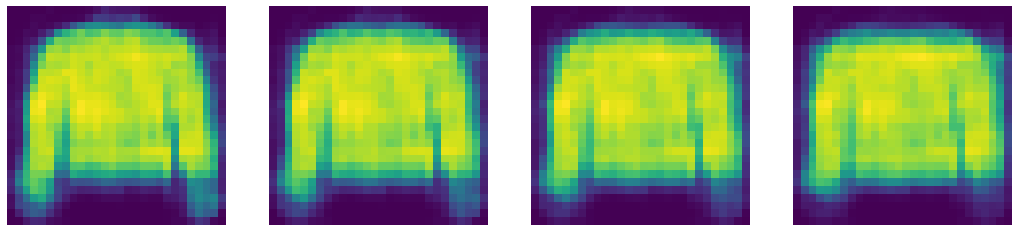

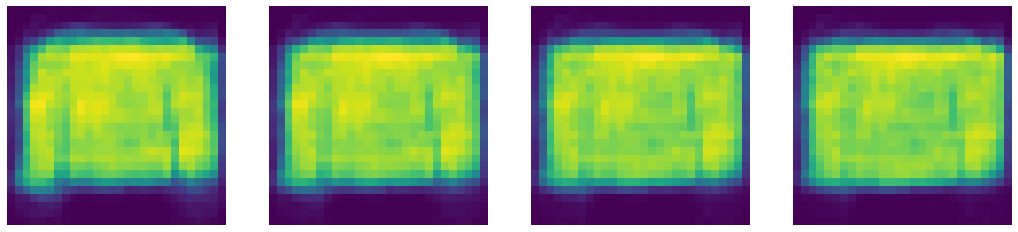

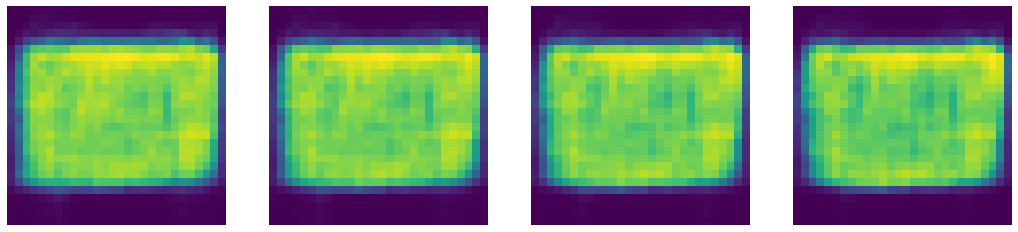

In [ ]:
# Perform an interpolation between input A and B, in N steps
N = 20
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
    sample = model.decoder(code)
for i in range(N//4):
    display_images(None, sample[i*4:4*(i+1)], 4)

### 3

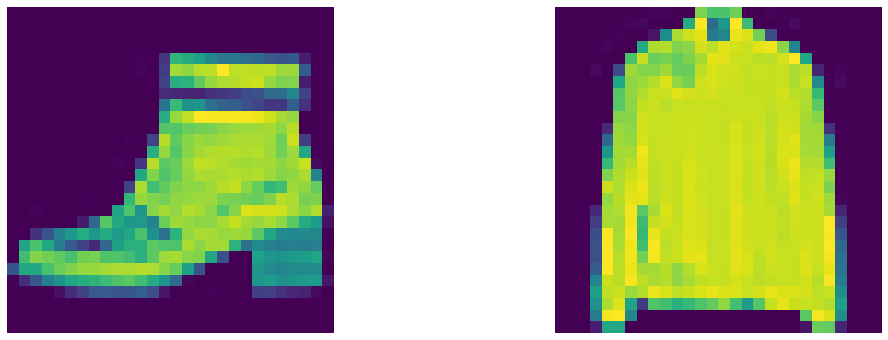

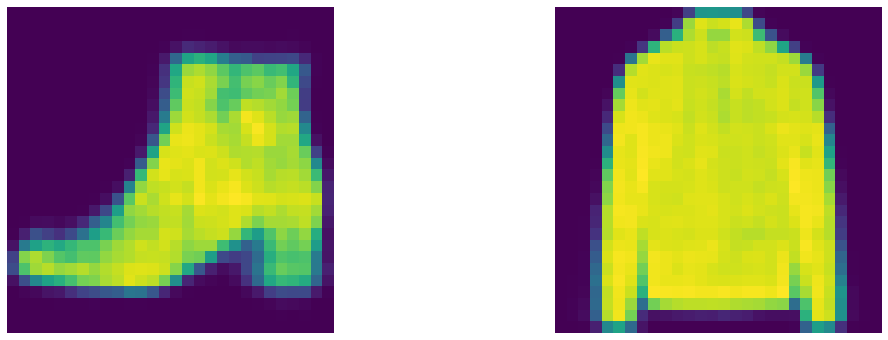

In [ ]:
x, _ = next(iter(test_loader))
x_hat, mu, logvar = model(x)
A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
#sample = torch.stack((x_hat[A].data, x_hat[B].data), 0)
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1)
)), 0), 2)
display_images(None, torch.stack(((
    sample.data[0],
    sample.data[1]
)), 0), 2)

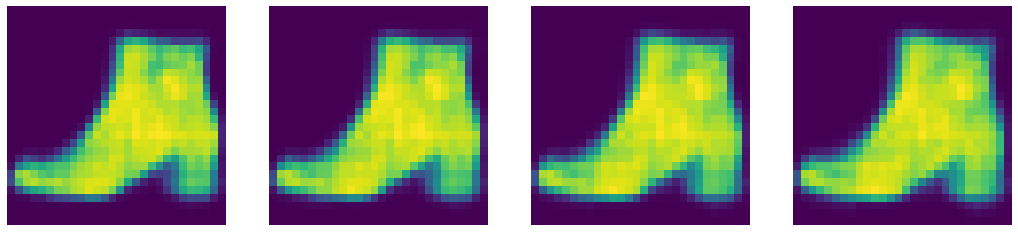

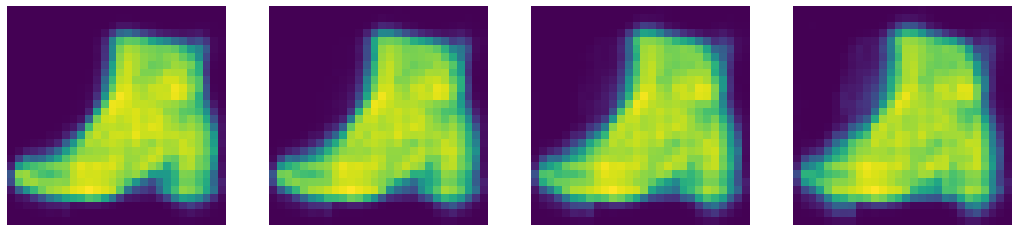

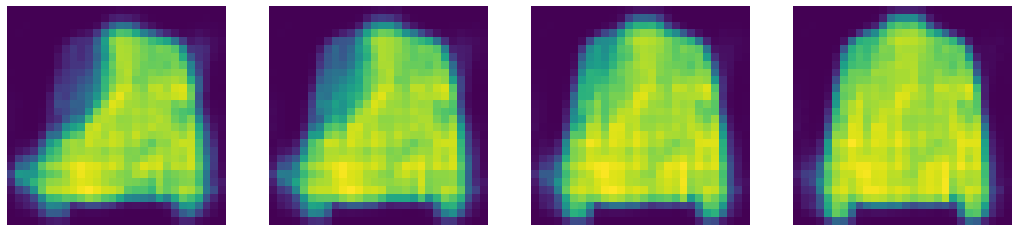

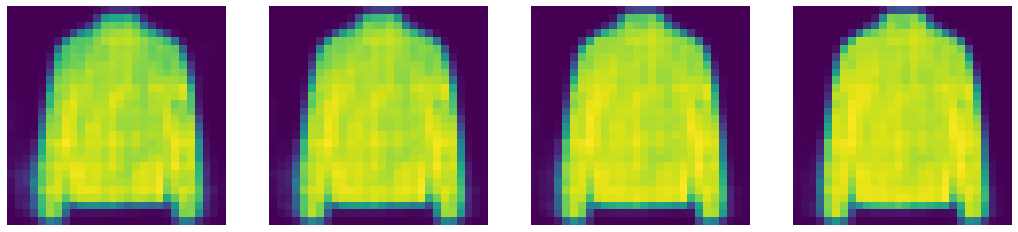

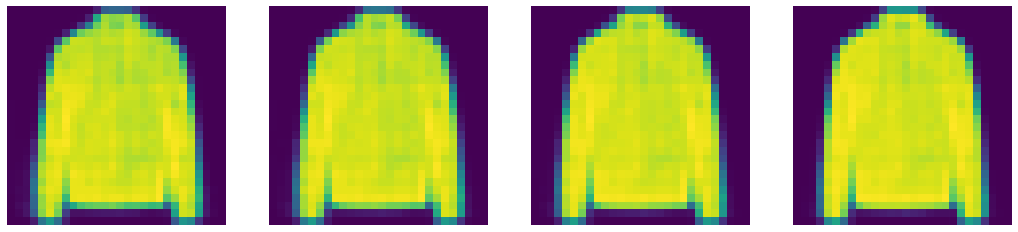

In [ ]:
# Perform an interpolation between input A and B, in N steps
N = 20
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
    sample = model.decoder(code)
for i in range(N//4):
    display_images(None, sample[i*4:4*(i+1)], 4)

### 4

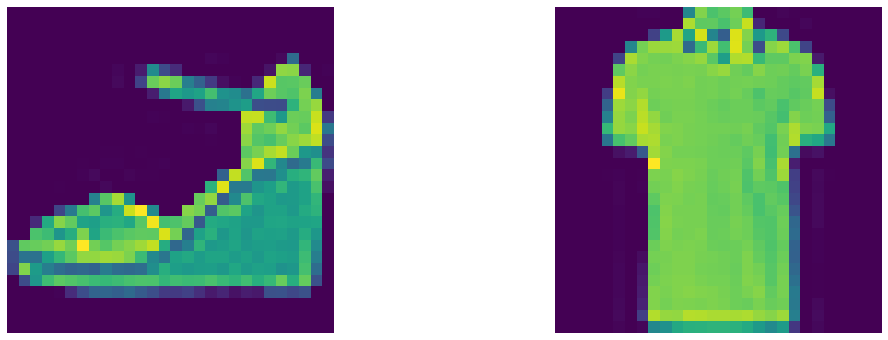

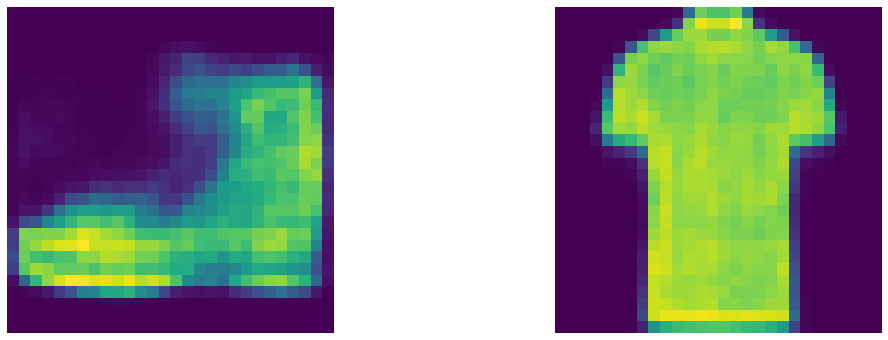

In [ ]:
x, _ = next(iter(test_loader))
x_hat, mu, logvar = model(x)
A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
#sample = torch.stack((x_hat[A].data, x_hat[B].data), 0)
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1)
)), 0), 2)
display_images(None, torch.stack(((
    sample.data[0],
    sample.data[1]
)), 0), 2)

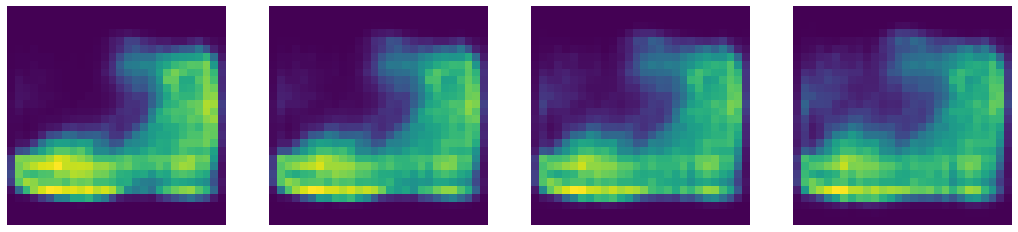

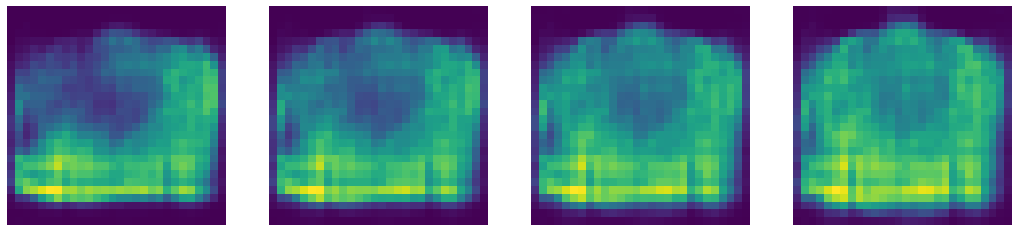

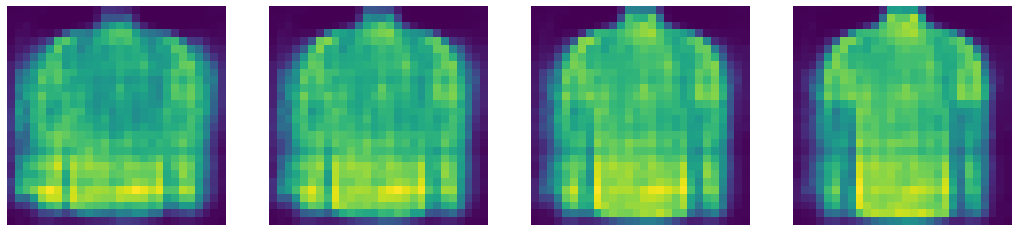

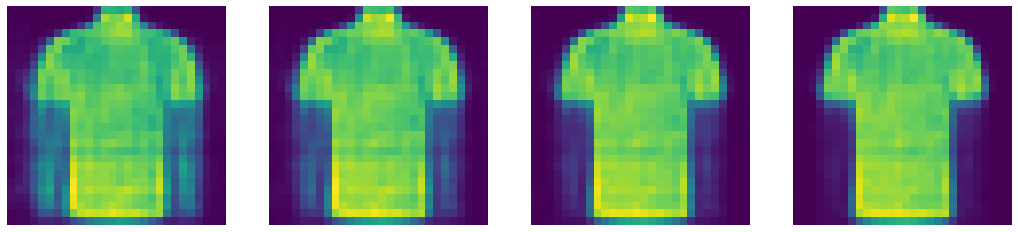

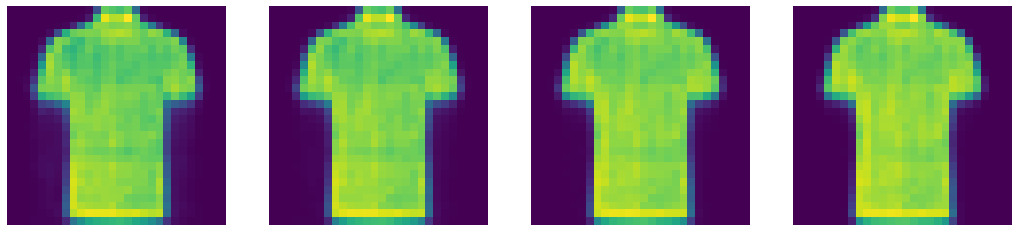

In [ ]:
# Perform an interpolation between input A and B, in N steps
N = 20
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
    sample = model.decoder(code)
for i in range(N//4):
    display_images(None, sample[i*4:4*(i+1)], 4)

### 5

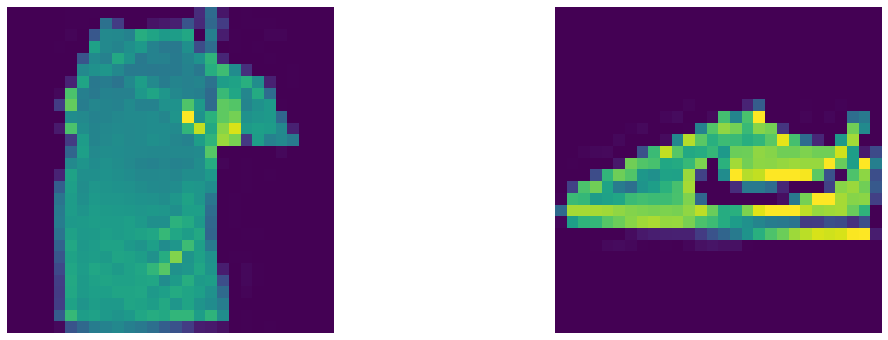

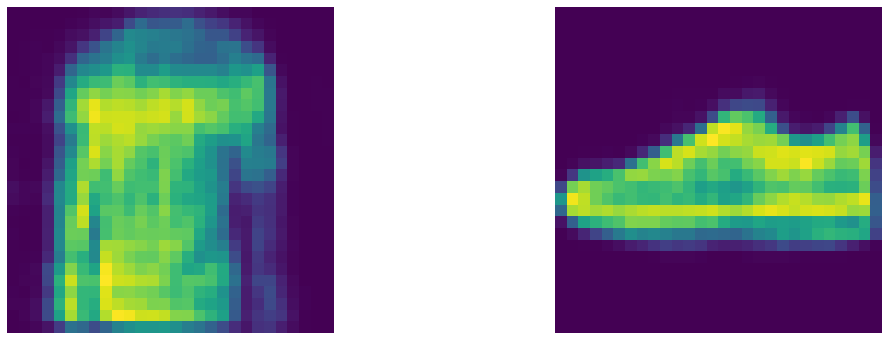

In [ ]:
x, _ = next(iter(test_loader))
x_hat, mu, logvar = model(x)
A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
#sample = torch.stack((x_hat[A].data, x_hat[B].data), 0)
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1)
)), 0), 2)
display_images(None, torch.stack(((
    sample.data[0],
    sample.data[1]
)), 0), 2)

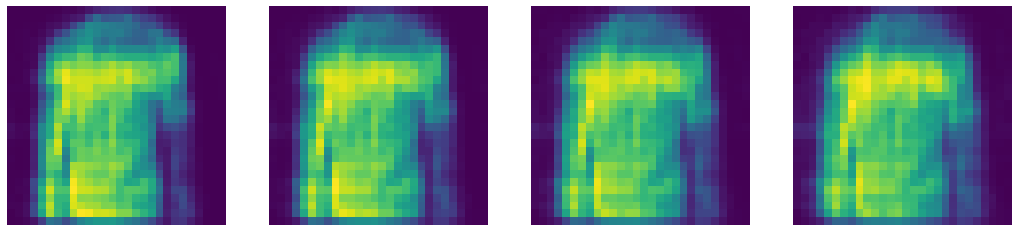

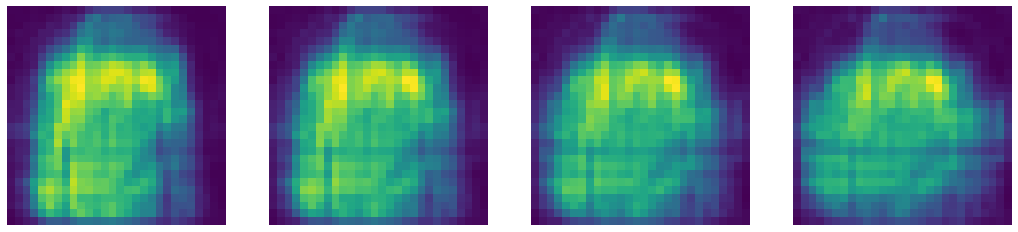

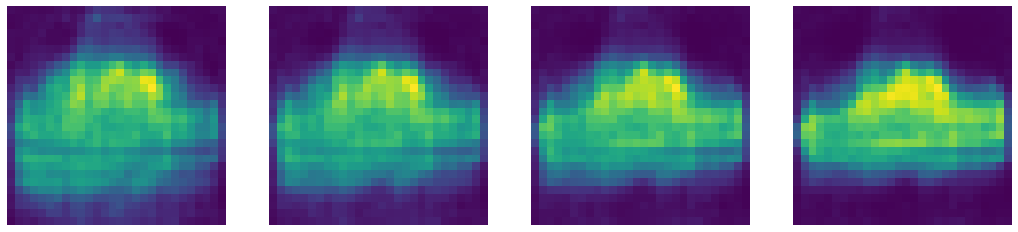

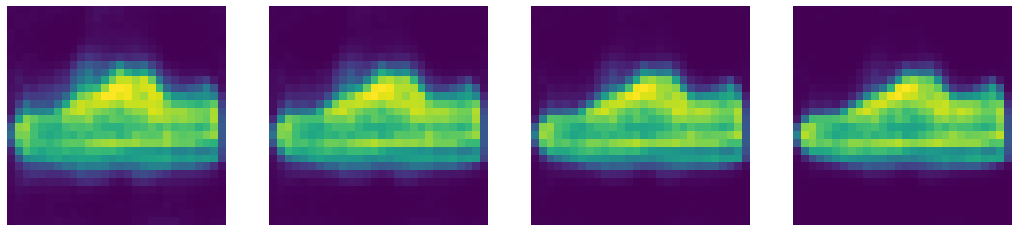

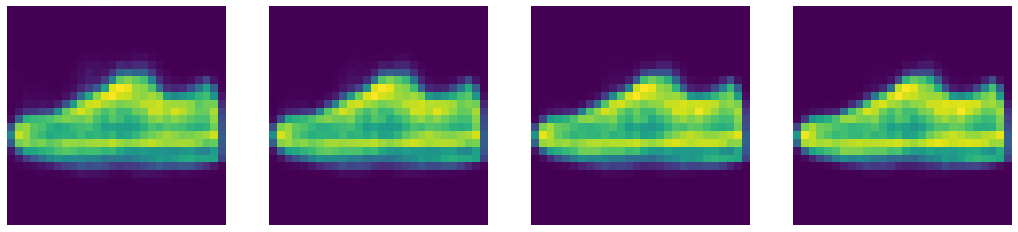

In [ ]:
# Perform an interpolation between input A and B, in N steps
N = 20
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
    sample = model.decoder(code)
for i in range(N//4):
    display_images(None, sample[i*4:4*(i+1)], 4)

# GAN 

## Import Libraries
At first we need to import the libraries. It is considered as standard imports.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from PIL import Image
from IPython.display import display
import cv2


import glob
import os
import random
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

## Dataloader and Visualization
Dataloader provides an iterable over the specified dataset by combining a dataset with a sampler.

In [5]:
# defining the image transform rules
'''
The augmentions are as follows, 
1. Resizing the image to 32x32 as the smaller the image the faster we can train 
2. Cropping from center with 32x32
3. Chagning type to tensor
we won't be using normalize here as we will have to do that manually later for tanh activation function
'''

transform_img = transforms.Compose([
        transforms.Resize(32),  
        transforms.CenterCrop(32),
        transforms.ToTensor()
    ])

In [6]:
def get_dataloader(batchsize, transforms):
    """
    Batch the neural network data using DataLoader
    :param batchsize: The size of each batch; the number of images in a batch
    :param transforms: data augmentations
    :return: DataLoader with batched data
    """
    
    data_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=True, download=True, transform=transform_img),
        batch_size=batchsize, shuffle=True, num_workers = 4)

    return data_loader

In [7]:
batch_size = 32 # Instead of individual samples, the data loader produces batched samples of given number
train_loader = get_dataloader(batch_size, transform_img)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [8]:
print(len(train_loader.dataset))

60000


In [9]:
# Let's see if the train loader is working and sending us iterable images :) 
# Also note that we converted images to tensor above with ToTensor(). Now we need to convert back to numpy to plot them

# obtain one batch of training images which means 32 images
dataiter = iter(train_loader)
img, _ = dataiter.next() # _ for labels, Dataloader sends labels automatically as defined in Dataloader class.

In [10]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

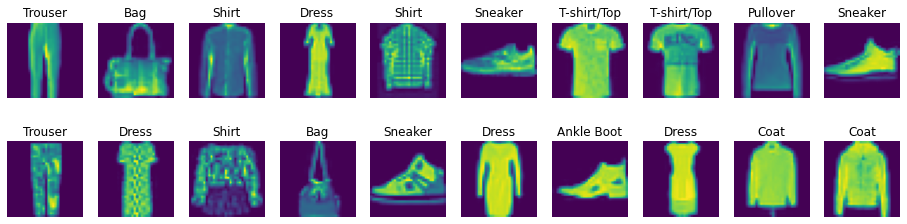

In [11]:
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(20):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(2, 10, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(output_label(label))


Now we need to scale our images as the output of a tanh activated generator will contain pixel values in a range from -1 to 1. So, we need to rescale our training images to a range of -1 to 1. 


In [12]:
def scale_images(x, max = 1.00 , min = -1.00):
    x = x * (max - min) + min
    return x

In [13]:
#let's check the scaling
img = img[5]
print('Before scaling min: ', img.min())
print('Before scaling max: ', img.max())

scaled_img = scale_images(img)

print('After Scaling Min: ', scaled_img.min())
print('After Scaling Max: ', scaled_img.max())

Before scaling min:  tensor(0.)
Before scaling max:  tensor(0.9333)
After Scaling Min:  tensor(-1.)
After Scaling Max:  tensor(0.8667)



Now our min and max are in range of [-1,1]

## Defining Model



### Discriminator
The discriminator is a classifier that detects if the input samples are genuine or fabricated. As a result, the discriminator in a GAN is essentially a classifier. It attempts to discern between genuine data and data generated by the generator. It could utilize any network architecture suitable for the type of data it's classifying. Here I will be using convolutional classifier, only without any maxpooling layers. It is recommended to employ a deep network with normalization to deal with this kind of difficult data.

In [14]:
'''
The inputs to the discriminator are 32x32x3 tensor images
The output would be a single value that will indicate whether a given image is real or fake
'''
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding)
    #appending convolutional layer
    layers.append(conv_layer)
    #appending batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [15]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initializing the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer based on which we will create the  next ones where next  layer depth = 2 * previous layer depth
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        
        self.conv1 = conv(1, conv_dim, batch_norm=False)  
        self.conv2 = conv(conv_dim, conv_dim*2)           
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        self.conv4 = conv(conv_dim*4, conv_dim*8)
        self.fc = nn.Linear(conv_dim*4*4*2, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        x = x.view(-1, self.conv_dim*4*2*4)
        
        x = self.fc(x)
        
        
        return x


### Generator 

The name,itself is self explanatory. The generator component of a GAN learns to generate fake data by incorporating discriminator feedback. It learns to manipulate the discriminator so that its output is classified as real. The generator should upsample an input and create a new image with the same dimensions as our training data (28x28x3). This should mostly consist of transpose convolutional layers with normalzed output.


In [16]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []
    
    # append transpose conv layer -- we are not using bias terms in conv layers
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))
    
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [17]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        # complete init function
        
        self.de_conv1 = deconv(conv_dim*4, conv_dim*2)
        self.de_conv2 = deconv(conv_dim*2, conv_dim)
        self.de_conv3 = deconv(conv_dim, 1, 4, batch_norm=False )
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = self.dropout(x)
        
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.de_conv1(x))
        x = F.relu(self.de_conv2(x))
        x = self.de_conv3(x)
        x = F.tanh(x)
        
        
        return x

In [18]:
#Initializing the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.

def weights_init_normal(m):
    """
    :param m: A module or layer in a network    
    """
    # like `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    #  initial weights to convolutional and linear layers
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal(m.weight.data, 0.0, 0.2)
        
    if hasattr(m, 'bias') and m.bias is not None:
        nn.init.constant(m.bias.data, 0.0)

In [19]:
# model hyperparameters
d_conv_dim = 64
g_conv_dim = 128
z_size = 100
# building discriminator and generator from the classes defined above
discriminator = Discriminator(d_conv_dim)
generator = Generator(z_size=z_size, conv_dim=g_conv_dim)

# initialize model weights
discriminator.apply(weights_init_normal)
generator.apply(weights_init_normal)
print("done")

done


## Training the model

### Optimizers


In [20]:
use_gpu = torch.cuda.is_available()

lr = 0.0002 #learning rate
beta1=0.5
beta2=0.999

# optimizers for the discriminator D and generator G
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr, (beta1, beta2)) # for discriminator
generator_optimizer = torch.optim.Adam(generator.parameters(), lr, (beta1, beta2)) # for generator

### Loss functions for generator
The generator's goal is to get the discriminator to think its generated images are real.


In [21]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
    
    if use_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if use_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [22]:
def train(D, G, n_epochs, train_on_gpu, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(train_loader):

            batch_size = real_images.size(0)
            real_images = scale_images(real_images)

            # Train the discriminator on real and fake images
            discriminator_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)      # Calculates log(D(x))

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            discriminator_optimizer.step()     

            # 2. Train the generator with an adversarial loss
            generator_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            D_fake = D(fake_images)
            
            g_loss = real_loss(D_fake)  # The Generator wishies to minimize the real_loss for it's fake output
                                        # to trick the Discriminator
        
            g_loss.backward()
            generator_optimizer.step()
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [55]:
n_epochs = 12

losses = train(discriminator, generator, n_epochs=n_epochs, train_on_gpu = use_gpu)

Epoch [    1/   12] | d_loss: 0.0012 | g_loss: 7.7325
Epoch [    1/   12] | d_loss: 0.0013 | g_loss: 9.2817
Epoch [    1/   12] | d_loss: 0.0010 | g_loss: 10.8460
Epoch [    1/   12] | d_loss: 0.0004 | g_loss: 11.3522
Epoch [    1/   12] | d_loss: 0.0001 | g_loss: 14.2718
Epoch [    1/   12] | d_loss: 0.0325 | g_loss: 8.9351
Epoch [    1/   12] | d_loss: 0.0002 | g_loss: 9.8340
Epoch [    1/   12] | d_loss: 0.0405 | g_loss: 5.4383
Epoch [    1/   12] | d_loss: 0.0018 | g_loss: 9.6785
Epoch [    1/   12] | d_loss: 0.0072 | g_loss: 9.7214
Epoch [    1/   12] | d_loss: 0.0829 | g_loss: 9.7722
Epoch [    1/   12] | d_loss: 0.0044 | g_loss: 9.3301
Epoch [    1/   12] | d_loss: 0.0160 | g_loss: 12.1168
Epoch [    1/   12] | d_loss: 0.0044 | g_loss: 6.6098
Epoch [    1/   12] | d_loss: 0.0022 | g_loss: 7.6875
Epoch [    1/   12] | d_loss: 0.0003 | g_loss: 10.4829
Epoch [    1/   12] | d_loss: 0.0009 | g_loss: 12.2823
Epoch [    1/   12] | d_loss: 0.0115 | g_loss: 12.5317
Epoch [    1/   12] |

### Training loss

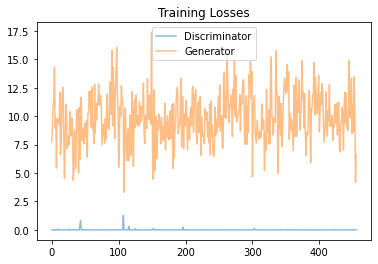

In [56]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Visualize the generated images




In [57]:
def view_samples(epoch, samples):
    plt.figure(figsize=(12, 5))
    batch=samples[epoch]
    for i in range(10):
        image = batch[i].detach().cpu()
        plt.subplot(2, 10, i + 1)
        plt.imshow(image.squeeze().numpy())
        plt.axis('off')

In [62]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

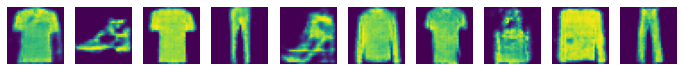

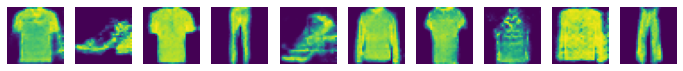

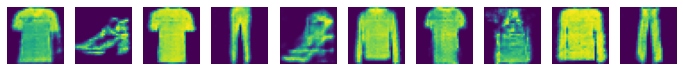

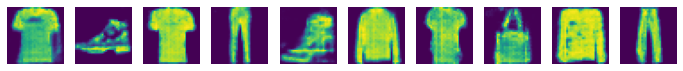

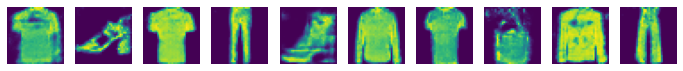

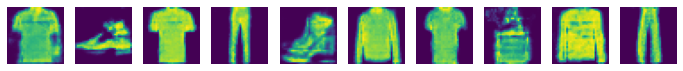

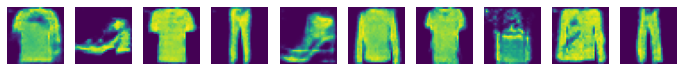

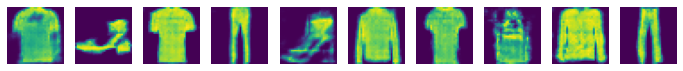

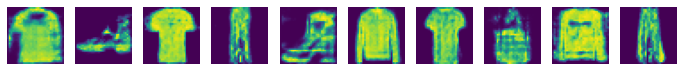

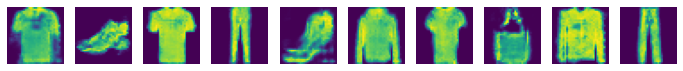

In [63]:
for i in range(10):
    _ = view_samples(i, samples)